In [30]:
import matplotlib.pyplot as plt 
import drjit as dr
import mitsuba as mi
mi.set_variant("llvm_ad_rgb")

In [31]:
mi.variants()

['scalar_rgb',
 'scalar_spectral',
 'cuda_ad_rgb',
 'llvm_ad_rgb',
 'llvm_mono',
 'llvm_ad_mono',
 'cuda_ad_mono',
 'cuda_ad_spectral',
 'cuda_spectral',
 'cuda_mono',
 'llvm_ad_spectral',
 'llvm_spectral']

### Creating multiple sensors

We cannot hope to obtain a robust volumetric reconstruction using only a single reference image. Multiple viewpoints are needed to sufficiently constrain the reconstructed volume density.  Using a multi-view optimization we can recover volume parameters that generalize to novel views (and illumination conditions).

In this tutorial, we use 5 sensors placed on a half circle around the origin. For the simple optimization in this tutorial this is sufficient, but more complex scenes may require using significantly more views (e.g., using 50-100 sensors is not unreasonable).

In [32]:
from mitsuba import ScalarTransform4f as T

sensor_count = 5
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0
    sensor_rotation = T.rotate([0, 1, 0], angle)
    sensor_to_world = T.look_at(target=[0, 0, 0], origin=[0, 4, 4], up=[0, 1, 0])
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 60,
        'to_world': sensor_rotation @ sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 128, 'height': 128,
            'filter': {'type': 'tent'},
            'pixel_format':'luminance'
        }
    }))


## Rendering synthetic reference images

We will now setup a simple scene with a constant environment illumination and a reference volume placed at the origin. The heterogenous volume is instantiated inside of a cube. We assign the `null` BSDF to the cube's surface, since we do not want the cube's surface to interact with light in any way (i.e., the surface should be invisible). To learn more about volume rendering in Mitsuba, please refer to the [plugin documentation][1].

We then render this scene using the previously created sensors and store the resulting images in a list for later use.


[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_media.html#heterogeneous-medium-heterogeneous

In [33]:
scene_dict = {
    'type': 'scene',
    'integrator': {'type': 'prbvolpath'},
    'object': {
        'type': 'cube',
        'bsdf': {'type': 'null'},
        'to_world': T.scale(3),
        'interior': {
            'type': 'heterogeneous',
            'sigma_t': {
                'type': 'gridvolume',
                'filename': 'scenes/volume.vol',
                'to_world': T.rotate([1, 0, 0], -90).scale(10).translate(-0.5)
            },
            'albedo': 0.99,
            'scale': 1
        }
    },
    'bunny':{
        'type': 'ply',
        'filename': 'scenes/meshes/bunny.ply',
        'to_world':T.translate(-0.25).translate([-0.5,-0.5,0.5]).scale(8),
        'bsdf':{'type':'diffuse' ,'reflectance': 0.1}
    },
    'emitter_light': {'type': 'constant','radiance': {'type': 'spectrum',"value": 0.9}}
}

scene_ref = mi.load_dict(scene_dict)

# Number of samples per pixel for reference images
ref_spp = 128

In [34]:
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]

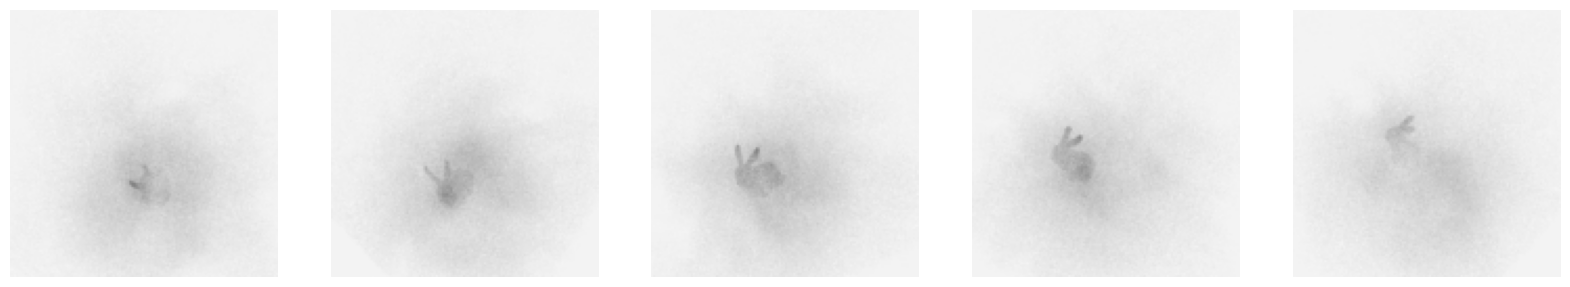

In [35]:
fig, axs = plt.subplots(1, sensor_count, figsize=(20, 10))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[i].axis('off')